In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("code")

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wave
from tqdm import tqdm_notebook

In [2]:
rate, x = wave.read("data/mix.wav")
T, I = x.shape
J = 3

print("rate = {}".format(rate))
print("T = {}".format(T))
print("I = {}".format(I))
print("J = {}".format(J))

rate = 22050
T = 220501
I = 2
J = 3


(2, 501, 443)
F = 501
N = 443


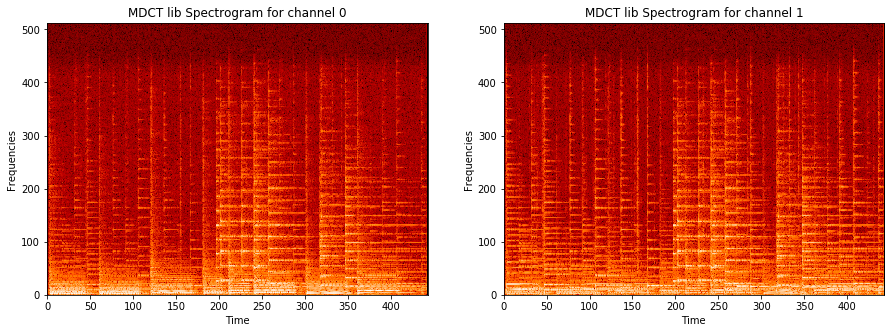

In [3]:
import scipy.signal as sig
freqs, _, x_four = sig.stft(x.transpose(), fs = rate, nperseg = 1000)
F = len(freqs)
N = x_four.shape[-1]
print(x_four.shape)
print("F = {}".format(F))
print("N = {}".format(N))

def plot_ft(Z):
    
    plt.figure(figsize = (15, 5))
    eps = 1e-10
    for i in range(Z.shape[0]):
        plt.subplot(101 + Z.shape[0] * 10 + i)

        logmag = np.flipud(np.log(eps + np.real(Z[i])**2))
        plt.imshow(logmag, extent=[0, logmag.shape[-1], 0, 512], aspect = 'auto', cmap = plt.cm.gist_heat)
        plt.title("MDCT lib Spectrogram for channel {}".format(i))
        plt.ylabel("Frequencies")
        plt.xlabel("Time")
    plt.show()
    
plot_ft(x_four)

In [4]:
def compute_Rxx(x1, x2 = None):
    if x2 == None:
        x2 = x1
    return x1.dot(x2.getH()) / x1.shape[-1]

Rxx = np.array([compute_Rxx(np.matrix(x_four[i])) for i in range(len(x_four))]).transpose()

# Parameters of the model

In [5]:
K = J + 1

A = np.zeros((I, J, F), dtype=complex)
W = np.zeros((F, K), dtype=complex)
H = np.zeros((K, N), dtype=complex)
Sb = np.zeros((F, I, I), dtype=complex)

A += np.random.random(A.shape)
W += np.random.random(W.shape)
H += np.random.random(H.shape)
Sb += np.random.random(Sb.shape)

In [6]:
def compute_Sc(W, H):
    F, K = W.shape
    _, N = H.shape
    
    W = np.array([W for n in range(N)]).transpose(1, 0, 2)
    H = np.array([H for f in range(F)]).transpose(0, 2, 1)
    return W * H
    
Sc = compute_Sc(W, H)
Kcal = [0, 2, 3]

In [7]:
def compute_Arond(A, K, Kcal):
    I, _, F = A.shape
    Arond = np.zeros((I, K, F), dtype=complex)
    for j, k in enumerate(Kcal):
        Arond[:, k] = A[:, j]
    return Arond

def compute_E_step(x_four, A, Sc, Sb, Kcal):
    F, N, K = Sc.shape
    I, J, _ = A.shape
    
    Ss = Sc[:, :, Kcal]
    Arond = compute_Arond(A, K, Kcal)
    
    Gs = np.empty((F, N, J, I), dtype=complex)
    Gc = np.empty((F, N, K, I), dtype=complex)
    s = np.empty((F, N, J), dtype=complex)
    c = np.empty((F, N, K), dtype=complex)
    
    Rxs = np.empty((F, I, J), dtype=complex)
    Rss = np.empty((F, J, J), dtype=complex)
    u = np.empty((K, F, N), dtype=complex)
    
    for f in tqdm_notebook(range(F)):
        for n in range(N):
            a = np.matrix(A[:, :, f])
            arond = np.matrix(Arond[:, :, f])
            ss = np.diag(Ss[f, n])
            sc = np.diag(Sc[f, n])
            
            sx = a.dot(ss).dot(a.getH()) + Sb[f]
            invsx = np.linalg.inv(sx)
            
            Gs[f, n] = ss.dot(a.getH()).dot(invsx)
            Gc[f, n] = sc.dot(arond.getH()).dot(invsx)
            
            s[f, n] = Gs[f, n].dot(x_four[:, f, n])
            c[f, n] = Gc[f, n].dot(x_four[:, f, n])
            
            Rxs[f] += np.matrix(x_four[:, f, n]).transpose().dot(np.matrix(s[f, n]).getH().transpose()) / N
            
            Rss[f] += np.matrix(s[f, n]).transpose().dot(np.matrix(s[f, n]).getH().transpose()) / N
            Rss[f] += ss
            Rss[f] -= Gs[f, n].dot(a).dot(ss)
            
            
            u[:, f, n] = np.matrix(c[f, n]) * np.matrix(c[f, n]).getH() + np.diagonal(sc + Gc[f, n].dot(arond).dot(sc))
            
    return Rxs, Rss, u
    
Rxs, Rss, u = compute_E_step(x_four, A, Sc, Sb, Kcal)

In [8]:
W.shape, H.shape, u.shape

((501, 4), (4, 443), (4, 501, 443))

In [9]:
H.shape

(4, 443)

In [10]:
def compute_M_step(Rxx, Rxs, Rss, u, H, W):
    F, I, J = Rxs.shape
    K, N = H.shape
    
    A = np.empty((I, J, F), dtype=complex)
    Sb = np.empty((F, I, I), dtype=complex)

    for f in range(F):

        A[:, :, f] = Rxs[f].dot(np.linalg.inv(Rss[f]))

        af = np.matrix(A[:, :, f])
        rxsf = np.matrix(Rxs[f])
        
        Sb[f] = - np.array(af.dot(rxsf.getH())) - np.array(rxsf.dot(af.getH())) + np.array(af.dot(Rss[f]).dot(af.getH()))
        Sb[f] += np.diag(Rxx[f, f])
        
        W[f] = np.sum(u[:, f] / H, axis = -1) / N
        
    for n in range(N):
        H[:, n] = np.sum(u[:, :, n] / W.transpose(), axis = -1) / F
            
    return A, Sb, H, W

A, Sb, H, W = compute_M_step(Rxx, Rxs, Rss, u, H, W)